In [1]:
!pip install -q tfds-nightly

# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
!pip install matplotlib==3.2.2

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [5]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [6]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [7]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [9]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [10]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [11]:
MAX_LENGTH = 40

In [12]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [13]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [14]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

In [15]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [16]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


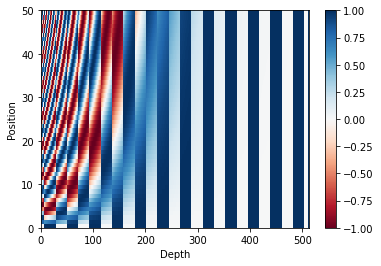

In [17]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [18]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [19]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [20]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [21]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [23]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [24]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [25]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [26]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [27]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [29]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [30]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [31]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [33]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [35]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [36]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [37]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [38]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [39]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [40]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [41]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [42]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [44]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

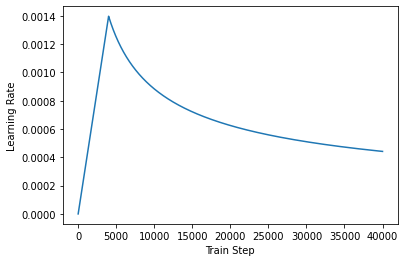

In [45]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [47]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [48]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [49]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [50]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [51]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [52]:
EPOCHS = 200

In [53]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [54]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.4804 Accuracy 0.4110
Epoch 1 Batch 50 Loss 0.4836 Accuracy 0.4114
Epoch 1 Batch 100 Loss 0.4951 Accuracy 0.4113
Epoch 1 Batch 150 Loss 0.4999 Accuracy 0.4114
Epoch 1 Batch 200 Loss 0.5058 Accuracy 0.4086
Epoch 1 Batch 250 Loss 0.5093 Accuracy 0.4068
Epoch 1 Batch 300 Loss 0.5135 Accuracy 0.4058
Epoch 1 Batch 350 Loss 0.5173 Accuracy 0.4053
Epoch 1 Batch 400 Loss 0.5205 Accuracy 0.4045
Epoch 1 Batch 450 Loss 0.5238 Accuracy 0.4037
Epoch 1 Batch 500 Loss 0.5268 Accuracy 0.4028
Epoch 1 Batch 550 Loss 0.5316 Accuracy 0.4022
Epoch 1 Batch 600 Loss 0.5356 Accuracy 0.4020
Epoch 1 Batch 650 Loss 0.5387 Accuracy 0.4023
Epoch 1 Batch 700 Loss 0.5430 Accuracy 0.4016
Epoch 1 Loss 0.5430 Accuracy 0.4017
Time taken for 1 epoch: 51.484150886535645 secs

Epoch 2 Batch 0 Loss 0.4642 Accuracy 0.4320
Epoch 2 Batch 50 Loss 0.4885 Accuracy 0.4114
Epoch 2 Batch 100 Loss 0.4843 Accuracy 0.4081
Epoch 2 Batch 150 Loss 0.4900 Accuracy 0.4079
Epoch 2 Batch 200 Loss 0.4961 Accuracy 0.4059
E

Epoch 11 Batch 400 Loss 0.4688 Accuracy 0.4111
Epoch 11 Batch 450 Loss 0.4734 Accuracy 0.4095
Epoch 11 Batch 500 Loss 0.4766 Accuracy 0.4092
Epoch 11 Batch 550 Loss 0.4802 Accuracy 0.4086
Epoch 11 Batch 600 Loss 0.4837 Accuracy 0.4085
Epoch 11 Batch 650 Loss 0.4881 Accuracy 0.4080
Epoch 11 Batch 700 Loss 0.4912 Accuracy 0.4072
Epoch 11 Loss 0.4913 Accuracy 0.4072
Time taken for 1 epoch: 35.24862575531006 secs

Epoch 12 Batch 0 Loss 0.4580 Accuracy 0.4001
Epoch 12 Batch 50 Loss 0.4329 Accuracy 0.4082
Epoch 12 Batch 100 Loss 0.4398 Accuracy 0.4091
Epoch 12 Batch 150 Loss 0.4448 Accuracy 0.4099
Epoch 12 Batch 200 Loss 0.4515 Accuracy 0.4087
Epoch 12 Batch 250 Loss 0.4549 Accuracy 0.4086
Epoch 12 Batch 300 Loss 0.4585 Accuracy 0.4080
Epoch 12 Batch 350 Loss 0.4613 Accuracy 0.4089
Epoch 12 Batch 400 Loss 0.4658 Accuracy 0.4087
Epoch 12 Batch 450 Loss 0.4692 Accuracy 0.4089
Epoch 12 Batch 500 Loss 0.4738 Accuracy 0.4085
Epoch 12 Batch 550 Loss 0.4775 Accuracy 0.4073
Epoch 12 Batch 600 Loss 0

Epoch 21 Batch 650 Loss 0.4448 Accuracy 0.4135
Epoch 21 Batch 700 Loss 0.4488 Accuracy 0.4131
Epoch 21 Loss 0.4489 Accuracy 0.4132
Time taken for 1 epoch: 35.172932624816895 secs

Epoch 22 Batch 0 Loss 0.4073 Accuracy 0.4844
Epoch 22 Batch 50 Loss 0.4019 Accuracy 0.4183
Epoch 22 Batch 100 Loss 0.4012 Accuracy 0.4157
Epoch 22 Batch 150 Loss 0.4061 Accuracy 0.4135
Epoch 22 Batch 200 Loss 0.4107 Accuracy 0.4143
Epoch 22 Batch 250 Loss 0.4161 Accuracy 0.4140
Epoch 22 Batch 300 Loss 0.4201 Accuracy 0.4144
Epoch 22 Batch 350 Loss 0.4239 Accuracy 0.4148
Epoch 22 Batch 400 Loss 0.4266 Accuracy 0.4146
Epoch 22 Batch 450 Loss 0.4294 Accuracy 0.4139
Epoch 22 Batch 500 Loss 0.4333 Accuracy 0.4135
Epoch 22 Batch 550 Loss 0.4365 Accuracy 0.4136
Epoch 22 Batch 600 Loss 0.4400 Accuracy 0.4133
Epoch 22 Batch 650 Loss 0.4432 Accuracy 0.4127
Epoch 22 Batch 700 Loss 0.4462 Accuracy 0.4125
Epoch 22 Loss 0.4463 Accuracy 0.4126
Time taken for 1 epoch: 35.201555252075195 secs

Epoch 23 Batch 0 Loss 0.4033 Acc

Epoch 32 Batch 50 Loss 0.3617 Accuracy 0.4197
Epoch 32 Batch 100 Loss 0.3657 Accuracy 0.4166
Epoch 32 Batch 150 Loss 0.3706 Accuracy 0.4198
Epoch 32 Batch 200 Loss 0.3762 Accuracy 0.4189
Epoch 32 Batch 250 Loss 0.3819 Accuracy 0.4201
Epoch 32 Batch 300 Loss 0.3850 Accuracy 0.4192
Epoch 32 Batch 350 Loss 0.3889 Accuracy 0.4187
Epoch 32 Batch 400 Loss 0.3941 Accuracy 0.4178
Epoch 32 Batch 450 Loss 0.3979 Accuracy 0.4177
Epoch 32 Batch 500 Loss 0.4007 Accuracy 0.4174
Epoch 32 Batch 550 Loss 0.4036 Accuracy 0.4173
Epoch 32 Batch 600 Loss 0.4069 Accuracy 0.4172
Epoch 32 Batch 650 Loss 0.4099 Accuracy 0.4166
Epoch 32 Batch 700 Loss 0.4128 Accuracy 0.4164
Epoch 32 Loss 0.4129 Accuracy 0.4163
Time taken for 1 epoch: 35.376795053482056 secs

Epoch 33 Batch 0 Loss 0.3350 Accuracy 0.4469
Epoch 33 Batch 50 Loss 0.3650 Accuracy 0.4270
Epoch 33 Batch 100 Loss 0.3690 Accuracy 0.4222
Epoch 33 Batch 150 Loss 0.3752 Accuracy 0.4216
Epoch 33 Batch 200 Loss 0.3771 Accuracy 0.4208
Epoch 33 Batch 250 Loss 0

Epoch 42 Batch 300 Loss 0.3605 Accuracy 0.4224
Epoch 42 Batch 350 Loss 0.3629 Accuracy 0.4228
Epoch 42 Batch 400 Loss 0.3659 Accuracy 0.4232
Epoch 42 Batch 450 Loss 0.3693 Accuracy 0.4229
Epoch 42 Batch 500 Loss 0.3727 Accuracy 0.4220
Epoch 42 Batch 550 Loss 0.3757 Accuracy 0.4217
Epoch 42 Batch 600 Loss 0.3785 Accuracy 0.4210
Epoch 42 Batch 650 Loss 0.3814 Accuracy 0.4207
Epoch 42 Batch 700 Loss 0.3841 Accuracy 0.4203
Epoch 42 Loss 0.3841 Accuracy 0.4203
Time taken for 1 epoch: 36.78624367713928 secs

Epoch 43 Batch 0 Loss 0.2940 Accuracy 0.4652
Epoch 43 Batch 50 Loss 0.3421 Accuracy 0.4297
Epoch 43 Batch 100 Loss 0.3465 Accuracy 0.4247
Epoch 43 Batch 150 Loss 0.3496 Accuracy 0.4240
Epoch 43 Batch 200 Loss 0.3517 Accuracy 0.4247
Epoch 43 Batch 250 Loss 0.3556 Accuracy 0.4244
Epoch 43 Batch 300 Loss 0.3593 Accuracy 0.4233
Epoch 43 Batch 350 Loss 0.3625 Accuracy 0.4225
Epoch 43 Batch 400 Loss 0.3665 Accuracy 0.4225
Epoch 43 Batch 450 Loss 0.3683 Accuracy 0.4228
Epoch 43 Batch 500 Loss 0

Epoch 52 Batch 550 Loss 0.3542 Accuracy 0.4224
Epoch 52 Batch 600 Loss 0.3573 Accuracy 0.4223
Epoch 52 Batch 650 Loss 0.3598 Accuracy 0.4221
Epoch 52 Batch 700 Loss 0.3628 Accuracy 0.4222
Epoch 52 Loss 0.3630 Accuracy 0.4222
Time taken for 1 epoch: 35.74028515815735 secs

Epoch 53 Batch 0 Loss 0.3330 Accuracy 0.3902
Epoch 53 Batch 50 Loss 0.3195 Accuracy 0.4235
Epoch 53 Batch 100 Loss 0.3281 Accuracy 0.4236
Epoch 53 Batch 150 Loss 0.3308 Accuracy 0.4237
Epoch 53 Batch 200 Loss 0.3333 Accuracy 0.4238
Epoch 53 Batch 250 Loss 0.3378 Accuracy 0.4240
Epoch 53 Batch 300 Loss 0.3416 Accuracy 0.4247
Epoch 53 Batch 350 Loss 0.3426 Accuracy 0.4240
Epoch 53 Batch 400 Loss 0.3456 Accuracy 0.4239
Epoch 53 Batch 450 Loss 0.3478 Accuracy 0.4232
Epoch 53 Batch 500 Loss 0.3503 Accuracy 0.4227
Epoch 53 Batch 550 Loss 0.3527 Accuracy 0.4231
Epoch 53 Batch 600 Loss 0.3559 Accuracy 0.4229
Epoch 53 Batch 650 Loss 0.3586 Accuracy 0.4230
Epoch 53 Batch 700 Loss 0.3613 Accuracy 0.4227
Epoch 53 Loss 0.3614 Accu

Epoch 63 Batch 50 Loss 0.3003 Accuracy 0.4314
Epoch 63 Batch 100 Loss 0.3025 Accuracy 0.4331
Epoch 63 Batch 150 Loss 0.3101 Accuracy 0.4325
Epoch 63 Batch 200 Loss 0.3137 Accuracy 0.4302
Epoch 63 Batch 250 Loss 0.3188 Accuracy 0.4300
Epoch 63 Batch 300 Loss 0.3217 Accuracy 0.4298
Epoch 63 Batch 350 Loss 0.3247 Accuracy 0.4280
Epoch 63 Batch 400 Loss 0.3267 Accuracy 0.4275
Epoch 63 Batch 450 Loss 0.3292 Accuracy 0.4273
Epoch 63 Batch 500 Loss 0.3313 Accuracy 0.4268
Epoch 63 Batch 550 Loss 0.3339 Accuracy 0.4261
Epoch 63 Batch 600 Loss 0.3372 Accuracy 0.4262
Epoch 63 Batch 650 Loss 0.3395 Accuracy 0.4261
Epoch 63 Batch 700 Loss 0.3422 Accuracy 0.4258
Epoch 63 Loss 0.3424 Accuracy 0.4258
Time taken for 1 epoch: 37.33968424797058 secs

Epoch 64 Batch 0 Loss 0.3125 Accuracy 0.4502
Epoch 64 Batch 50 Loss 0.3064 Accuracy 0.4308
Epoch 64 Batch 100 Loss 0.3056 Accuracy 0.4273
Epoch 64 Batch 150 Loss 0.3108 Accuracy 0.4271
Epoch 64 Batch 200 Loss 0.3122 Accuracy 0.4267
Epoch 64 Batch 250 Loss 0.

Epoch 73 Batch 300 Loss 0.3075 Accuracy 0.4288
Epoch 73 Batch 350 Loss 0.3102 Accuracy 0.4292
Epoch 73 Batch 400 Loss 0.3134 Accuracy 0.4294
Epoch 73 Batch 450 Loss 0.3156 Accuracy 0.4292
Epoch 73 Batch 500 Loss 0.3177 Accuracy 0.4286
Epoch 73 Batch 550 Loss 0.3206 Accuracy 0.4279
Epoch 73 Batch 600 Loss 0.3231 Accuracy 0.4280
Epoch 73 Batch 650 Loss 0.3255 Accuracy 0.4276
Epoch 73 Batch 700 Loss 0.3277 Accuracy 0.4271
Epoch 73 Loss 0.3278 Accuracy 0.4271
Time taken for 1 epoch: 36.40369701385498 secs

Epoch 74 Batch 0 Loss 0.2890 Accuracy 0.4514
Epoch 74 Batch 50 Loss 0.2951 Accuracy 0.4346
Epoch 74 Batch 100 Loss 0.2963 Accuracy 0.4336
Epoch 74 Batch 150 Loss 0.2981 Accuracy 0.4332
Epoch 74 Batch 200 Loss 0.2997 Accuracy 0.4330
Epoch 74 Batch 250 Loss 0.3036 Accuracy 0.4318
Epoch 74 Batch 300 Loss 0.3063 Accuracy 0.4307
Epoch 74 Batch 350 Loss 0.3093 Accuracy 0.4303
Epoch 74 Batch 400 Loss 0.3119 Accuracy 0.4298
Epoch 74 Batch 450 Loss 0.3142 Accuracy 0.4295
Epoch 74 Batch 500 Loss 0

Epoch 83 Batch 550 Loss 0.3053 Accuracy 0.4291
Epoch 83 Batch 600 Loss 0.3077 Accuracy 0.4289
Epoch 83 Batch 650 Loss 0.3106 Accuracy 0.4289
Epoch 83 Batch 700 Loss 0.3128 Accuracy 0.4293
Epoch 83 Loss 0.3128 Accuracy 0.4293
Time taken for 1 epoch: 36.6643340587616 secs

Epoch 84 Batch 0 Loss 0.2342 Accuracy 0.4491
Epoch 84 Batch 50 Loss 0.2801 Accuracy 0.4281
Epoch 84 Batch 100 Loss 0.2800 Accuracy 0.4292
Epoch 84 Batch 150 Loss 0.2835 Accuracy 0.4314
Epoch 84 Batch 200 Loss 0.2860 Accuracy 0.4333
Epoch 84 Batch 250 Loss 0.2875 Accuracy 0.4315
Epoch 84 Batch 300 Loss 0.2910 Accuracy 0.4315
Epoch 84 Batch 350 Loss 0.2929 Accuracy 0.4322
Epoch 84 Batch 400 Loss 0.2958 Accuracy 0.4317
Epoch 84 Batch 450 Loss 0.2989 Accuracy 0.4322
Epoch 84 Batch 500 Loss 0.3015 Accuracy 0.4320
Epoch 84 Batch 550 Loss 0.3032 Accuracy 0.4320
Epoch 84 Batch 600 Loss 0.3053 Accuracy 0.4314
Epoch 84 Batch 650 Loss 0.3079 Accuracy 0.4308
Epoch 84 Batch 700 Loss 0.3109 Accuracy 0.4303
Epoch 84 Loss 0.3110 Accur

Epoch 94 Batch 50 Loss 0.2705 Accuracy 0.4354
Epoch 94 Batch 100 Loss 0.2730 Accuracy 0.4353
Epoch 94 Batch 150 Loss 0.2741 Accuracy 0.4346
Epoch 94 Batch 200 Loss 0.2755 Accuracy 0.4342
Epoch 94 Batch 250 Loss 0.2786 Accuracy 0.4341
Epoch 94 Batch 300 Loss 0.2806 Accuracy 0.4339
Epoch 94 Batch 350 Loss 0.2836 Accuracy 0.4333
Epoch 94 Batch 400 Loss 0.2854 Accuracy 0.4337
Epoch 94 Batch 450 Loss 0.2877 Accuracy 0.4329
Epoch 94 Batch 500 Loss 0.2905 Accuracy 0.4328
Epoch 94 Batch 550 Loss 0.2924 Accuracy 0.4324
Epoch 94 Batch 600 Loss 0.2949 Accuracy 0.4322
Epoch 94 Batch 650 Loss 0.2976 Accuracy 0.4318
Epoch 94 Batch 700 Loss 0.2995 Accuracy 0.4312
Epoch 94 Loss 0.2996 Accuracy 0.4312
Time taken for 1 epoch: 36.27364444732666 secs

Epoch 95 Batch 0 Loss 0.3045 Accuracy 0.4439
Epoch 95 Batch 50 Loss 0.2660 Accuracy 0.4367
Epoch 95 Batch 100 Loss 0.2688 Accuracy 0.4330
Epoch 95 Batch 150 Loss 0.2709 Accuracy 0.4347
Epoch 95 Batch 200 Loss 0.2745 Accuracy 0.4354
Epoch 95 Batch 250 Loss 0.

Epoch 104 Batch 200 Loss 0.2666 Accuracy 0.4345
Epoch 104 Batch 250 Loss 0.2687 Accuracy 0.4355
Epoch 104 Batch 300 Loss 0.2706 Accuracy 0.4368
Epoch 104 Batch 350 Loss 0.2724 Accuracy 0.4363
Epoch 104 Batch 400 Loss 0.2743 Accuracy 0.4357
Epoch 104 Batch 450 Loss 0.2768 Accuracy 0.4347
Epoch 104 Batch 500 Loss 0.2787 Accuracy 0.4347
Epoch 104 Batch 550 Loss 0.2819 Accuracy 0.4350
Epoch 104 Batch 600 Loss 0.2843 Accuracy 0.4345
Epoch 104 Batch 650 Loss 0.2869 Accuracy 0.4341
Epoch 104 Batch 700 Loss 0.2892 Accuracy 0.4334
Epoch 104 Loss 0.2893 Accuracy 0.4334
Time taken for 1 epoch: 36.536051750183105 secs

Epoch 105 Batch 0 Loss 0.2697 Accuracy 0.4349
Epoch 105 Batch 50 Loss 0.2618 Accuracy 0.4389
Epoch 105 Batch 100 Loss 0.2606 Accuracy 0.4361
Epoch 105 Batch 150 Loss 0.2629 Accuracy 0.4347
Epoch 105 Batch 200 Loss 0.2655 Accuracy 0.4335
Epoch 105 Batch 250 Loss 0.2679 Accuracy 0.4337
Epoch 105 Batch 300 Loss 0.2707 Accuracy 0.4332
Epoch 105 Batch 350 Loss 0.2727 Accuracy 0.4338
Epoc

Epoch 114 Batch 250 Loss 0.2625 Accuracy 0.4363
Epoch 114 Batch 300 Loss 0.2653 Accuracy 0.4358
Epoch 114 Batch 350 Loss 0.2664 Accuracy 0.4356
Epoch 114 Batch 400 Loss 0.2685 Accuracy 0.4362
Epoch 114 Batch 450 Loss 0.2710 Accuracy 0.4359
Epoch 114 Batch 500 Loss 0.2732 Accuracy 0.4350
Epoch 114 Batch 550 Loss 0.2747 Accuracy 0.4345
Epoch 114 Batch 600 Loss 0.2768 Accuracy 0.4346
Epoch 114 Batch 650 Loss 0.2791 Accuracy 0.4345
Epoch 114 Batch 700 Loss 0.2808 Accuracy 0.4343
Epoch 114 Loss 0.2808 Accuracy 0.4343
Time taken for 1 epoch: 35.241804361343384 secs

Epoch 115 Batch 0 Loss 0.2381 Accuracy 0.4395
Epoch 115 Batch 50 Loss 0.2496 Accuracy 0.4297
Epoch 115 Batch 100 Loss 0.2494 Accuracy 0.4323
Epoch 115 Batch 150 Loss 0.2550 Accuracy 0.4342
Epoch 115 Batch 200 Loss 0.2561 Accuracy 0.4344
Epoch 115 Batch 250 Loss 0.2600 Accuracy 0.4342
Epoch 115 Batch 300 Loss 0.2609 Accuracy 0.4353
Epoch 115 Batch 350 Loss 0.2638 Accuracy 0.4354
Epoch 115 Batch 400 Loss 0.2657 Accuracy 0.4348
Epoc

Epoch 124 Batch 300 Loss 0.2552 Accuracy 0.4377
Epoch 124 Batch 350 Loss 0.2570 Accuracy 0.4376
Epoch 124 Batch 400 Loss 0.2588 Accuracy 0.4376
Epoch 124 Batch 450 Loss 0.2605 Accuracy 0.4370
Epoch 124 Batch 500 Loss 0.2626 Accuracy 0.4369
Epoch 124 Batch 550 Loss 0.2650 Accuracy 0.4364
Epoch 124 Batch 600 Loss 0.2669 Accuracy 0.4363
Epoch 124 Batch 650 Loss 0.2695 Accuracy 0.4358
Epoch 124 Batch 700 Loss 0.2718 Accuracy 0.4353
Epoch 124 Loss 0.2718 Accuracy 0.4353
Time taken for 1 epoch: 35.16764259338379 secs

Epoch 125 Batch 0 Loss 0.2273 Accuracy 0.4016
Epoch 125 Batch 50 Loss 0.2421 Accuracy 0.4356
Epoch 125 Batch 100 Loss 0.2426 Accuracy 0.4378
Epoch 125 Batch 150 Loss 0.2460 Accuracy 0.4376
Epoch 125 Batch 200 Loss 0.2493 Accuracy 0.4366
Epoch 125 Batch 250 Loss 0.2525 Accuracy 0.4365
Epoch 125 Batch 300 Loss 0.2545 Accuracy 0.4369
Epoch 125 Batch 350 Loss 0.2570 Accuracy 0.4368
Epoch 125 Batch 400 Loss 0.2577 Accuracy 0.4376
Epoch 125 Batch 450 Loss 0.2605 Accuracy 0.4366
Epoch

Epoch 134 Batch 350 Loss 0.2499 Accuracy 0.4393
Epoch 134 Batch 400 Loss 0.2513 Accuracy 0.4390
Epoch 134 Batch 450 Loss 0.2541 Accuracy 0.4383
Epoch 134 Batch 500 Loss 0.2565 Accuracy 0.4374
Epoch 134 Batch 550 Loss 0.2585 Accuracy 0.4374
Epoch 134 Batch 600 Loss 0.2607 Accuracy 0.4376
Epoch 134 Batch 650 Loss 0.2624 Accuracy 0.4371
Epoch 134 Batch 700 Loss 0.2649 Accuracy 0.4365
Epoch 134 Loss 0.2649 Accuracy 0.4365
Time taken for 1 epoch: 35.15655827522278 secs

Epoch 135 Batch 0 Loss 0.2239 Accuracy 0.4449
Epoch 135 Batch 50 Loss 0.2363 Accuracy 0.4377
Epoch 135 Batch 100 Loss 0.2391 Accuracy 0.4389
Epoch 135 Batch 150 Loss 0.2422 Accuracy 0.4369
Epoch 135 Batch 200 Loss 0.2446 Accuracy 0.4380
Epoch 135 Batch 250 Loss 0.2461 Accuracy 0.4371
Epoch 135 Batch 300 Loss 0.2475 Accuracy 0.4373
Epoch 135 Batch 350 Loss 0.2499 Accuracy 0.4369
Epoch 135 Batch 400 Loss 0.2516 Accuracy 0.4371
Epoch 135 Batch 450 Loss 0.2540 Accuracy 0.4369
Epoch 135 Batch 500 Loss 0.2558 Accuracy 0.4363
Epoch

Epoch 144 Batch 400 Loss 0.2458 Accuracy 0.4383
Epoch 144 Batch 450 Loss 0.2479 Accuracy 0.4378
Epoch 144 Batch 500 Loss 0.2497 Accuracy 0.4379
Epoch 144 Batch 550 Loss 0.2518 Accuracy 0.4374
Epoch 144 Batch 600 Loss 0.2543 Accuracy 0.4368
Epoch 144 Batch 650 Loss 0.2564 Accuracy 0.4363
Epoch 144 Batch 700 Loss 0.2580 Accuracy 0.4361
Epoch 144 Loss 0.2582 Accuracy 0.4362
Time taken for 1 epoch: 34.32992100715637 secs

Epoch 145 Batch 0 Loss 0.2319 Accuracy 0.4091
Epoch 145 Batch 50 Loss 0.2291 Accuracy 0.4355
Epoch 145 Batch 100 Loss 0.2322 Accuracy 0.4374
Epoch 145 Batch 150 Loss 0.2349 Accuracy 0.4369
Epoch 145 Batch 200 Loss 0.2369 Accuracy 0.4378
Epoch 145 Batch 250 Loss 0.2401 Accuracy 0.4392
Epoch 145 Batch 300 Loss 0.2419 Accuracy 0.4389
Epoch 145 Batch 350 Loss 0.2442 Accuracy 0.4385
Epoch 145 Batch 400 Loss 0.2453 Accuracy 0.4379
Epoch 145 Batch 450 Loss 0.2476 Accuracy 0.4388
Epoch 145 Batch 500 Loss 0.2497 Accuracy 0.4386
Epoch 145 Batch 550 Loss 0.2516 Accuracy 0.4389
Epoch

Epoch 154 Batch 450 Loss 0.2419 Accuracy 0.4400
Epoch 154 Batch 500 Loss 0.2431 Accuracy 0.4399
Epoch 154 Batch 550 Loss 0.2450 Accuracy 0.4391
Epoch 154 Batch 600 Loss 0.2471 Accuracy 0.4391
Epoch 154 Batch 650 Loss 0.2490 Accuracy 0.4390
Epoch 154 Batch 700 Loss 0.2513 Accuracy 0.4385
Epoch 154 Loss 0.2513 Accuracy 0.4385
Time taken for 1 epoch: 34.400733947753906 secs

Epoch 155 Batch 0 Loss 0.2171 Accuracy 0.4303
Epoch 155 Batch 50 Loss 0.2260 Accuracy 0.4440
Epoch 155 Batch 100 Loss 0.2272 Accuracy 0.4406
Epoch 155 Batch 150 Loss 0.2289 Accuracy 0.4416
Epoch 155 Batch 200 Loss 0.2314 Accuracy 0.4409
Epoch 155 Batch 250 Loss 0.2340 Accuracy 0.4413
Epoch 155 Batch 300 Loss 0.2363 Accuracy 0.4402
Epoch 155 Batch 350 Loss 0.2376 Accuracy 0.4400
Epoch 155 Batch 400 Loss 0.2387 Accuracy 0.4388
Epoch 155 Batch 450 Loss 0.2409 Accuracy 0.4386
Epoch 155 Batch 500 Loss 0.2427 Accuracy 0.4385
Epoch 155 Batch 550 Loss 0.2446 Accuracy 0.4385
Epoch 155 Batch 600 Loss 0.2472 Accuracy 0.4382
Epoc

Epoch 164 Batch 500 Loss 0.2394 Accuracy 0.4385
Epoch 164 Batch 550 Loss 0.2406 Accuracy 0.4387
Epoch 164 Batch 600 Loss 0.2417 Accuracy 0.4391
Epoch 164 Batch 650 Loss 0.2439 Accuracy 0.4390
Epoch 164 Batch 700 Loss 0.2458 Accuracy 0.4385
Epoch 164 Loss 0.2459 Accuracy 0.4385
Time taken for 1 epoch: 34.378846168518066 secs

Epoch 165 Batch 0 Loss 0.2159 Accuracy 0.3990
Epoch 165 Batch 50 Loss 0.2208 Accuracy 0.4384
Epoch 165 Batch 100 Loss 0.2212 Accuracy 0.4379
Epoch 165 Batch 150 Loss 0.2255 Accuracy 0.4372
Epoch 165 Batch 200 Loss 0.2281 Accuracy 0.4385
Epoch 165 Batch 250 Loss 0.2300 Accuracy 0.4380
Epoch 165 Batch 300 Loss 0.2324 Accuracy 0.4379
Epoch 165 Batch 350 Loss 0.2339 Accuracy 0.4373
Epoch 165 Batch 400 Loss 0.2350 Accuracy 0.4387
Epoch 165 Batch 450 Loss 0.2366 Accuracy 0.4388
Epoch 165 Batch 500 Loss 0.2383 Accuracy 0.4392
Epoch 165 Batch 550 Loss 0.2401 Accuracy 0.4395
Epoch 165 Batch 600 Loss 0.2413 Accuracy 0.4398
Epoch 165 Batch 650 Loss 0.2430 Accuracy 0.4390
Epoc

Epoch 174 Batch 550 Loss 0.2342 Accuracy 0.4402
Epoch 174 Batch 600 Loss 0.2358 Accuracy 0.4399
Epoch 174 Batch 650 Loss 0.2381 Accuracy 0.4396
Epoch 174 Batch 700 Loss 0.2398 Accuracy 0.4390
Epoch 174 Loss 0.2400 Accuracy 0.4390
Time taken for 1 epoch: 34.404698848724365 secs

Epoch 175 Batch 0 Loss 0.1755 Accuracy 0.4579
Epoch 175 Batch 50 Loss 0.2139 Accuracy 0.4383
Epoch 175 Batch 100 Loss 0.2162 Accuracy 0.4407
Epoch 175 Batch 150 Loss 0.2199 Accuracy 0.4396
Epoch 175 Batch 200 Loss 0.2228 Accuracy 0.4400
Epoch 175 Batch 250 Loss 0.2250 Accuracy 0.4392
Epoch 175 Batch 300 Loss 0.2272 Accuracy 0.4396
Epoch 175 Batch 350 Loss 0.2291 Accuracy 0.4391
Epoch 175 Batch 400 Loss 0.2313 Accuracy 0.4385
Epoch 175 Batch 450 Loss 0.2328 Accuracy 0.4389
Epoch 175 Batch 500 Loss 0.2341 Accuracy 0.4390
Epoch 175 Batch 550 Loss 0.2354 Accuracy 0.4394
Epoch 175 Batch 600 Loss 0.2369 Accuracy 0.4395
Epoch 175 Batch 650 Loss 0.2382 Accuracy 0.4393
Epoch 175 Batch 700 Loss 0.2402 Accuracy 0.4390
Savi

Epoch 184 Batch 600 Loss 0.2317 Accuracy 0.4400
Epoch 184 Batch 650 Loss 0.2336 Accuracy 0.4396
Epoch 184 Batch 700 Loss 0.2353 Accuracy 0.4397
Epoch 184 Loss 0.2355 Accuracy 0.4397
Time taken for 1 epoch: 34.402355909347534 secs

Epoch 185 Batch 0 Loss 0.1821 Accuracy 0.4347
Epoch 185 Batch 50 Loss 0.2113 Accuracy 0.4463
Epoch 185 Batch 100 Loss 0.2138 Accuracy 0.4459
Epoch 185 Batch 150 Loss 0.2173 Accuracy 0.4473
Epoch 185 Batch 200 Loss 0.2184 Accuracy 0.4456
Epoch 185 Batch 250 Loss 0.2196 Accuracy 0.4442
Epoch 185 Batch 300 Loss 0.2212 Accuracy 0.4434
Epoch 185 Batch 350 Loss 0.2222 Accuracy 0.4441
Epoch 185 Batch 400 Loss 0.2242 Accuracy 0.4436
Epoch 185 Batch 450 Loss 0.2266 Accuracy 0.4424
Epoch 185 Batch 500 Loss 0.2283 Accuracy 0.4420
Epoch 185 Batch 550 Loss 0.2297 Accuracy 0.4417
Epoch 185 Batch 600 Loss 0.2320 Accuracy 0.4409
Epoch 185 Batch 650 Loss 0.2341 Accuracy 0.4408
Epoch 185 Batch 700 Loss 0.2359 Accuracy 0.4405
Saving checkpoint for epoch 185 at ./checkpoints/tra

Epoch 194 Batch 650 Loss 0.2286 Accuracy 0.4404
Epoch 194 Batch 700 Loss 0.2303 Accuracy 0.4407
Epoch 194 Loss 0.2304 Accuracy 0.4407
Time taken for 1 epoch: 34.35343647003174 secs

Epoch 195 Batch 0 Loss 0.2185 Accuracy 0.4443
Epoch 195 Batch 50 Loss 0.2044 Accuracy 0.4367
Epoch 195 Batch 100 Loss 0.2062 Accuracy 0.4408
Epoch 195 Batch 150 Loss 0.2088 Accuracy 0.4411
Epoch 195 Batch 200 Loss 0.2117 Accuracy 0.4408
Epoch 195 Batch 250 Loss 0.2147 Accuracy 0.4402
Epoch 195 Batch 300 Loss 0.2170 Accuracy 0.4417
Epoch 195 Batch 350 Loss 0.2181 Accuracy 0.4424
Epoch 195 Batch 400 Loss 0.2202 Accuracy 0.4421
Epoch 195 Batch 450 Loss 0.2215 Accuracy 0.4420
Epoch 195 Batch 500 Loss 0.2229 Accuracy 0.4417
Epoch 195 Batch 550 Loss 0.2246 Accuracy 0.4415
Epoch 195 Batch 600 Loss 0.2262 Accuracy 0.4409
Epoch 195 Batch 650 Loss 0.2279 Accuracy 0.4411
Epoch 195 Batch 700 Loss 0.2296 Accuracy 0.4409
Saving checkpoint for epoch 195 at ./checkpoints/train/ckpt-51
Epoch 195 Loss 0.2296 Accuracy 0.4409


In [55]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [56]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [57]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [58]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem we need to solve us .
Real translation: this is a problem we have to solve .


In [59]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [60]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to be quickly share with you some magic stories that have happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted translation: that 's the first book i did when i was do .


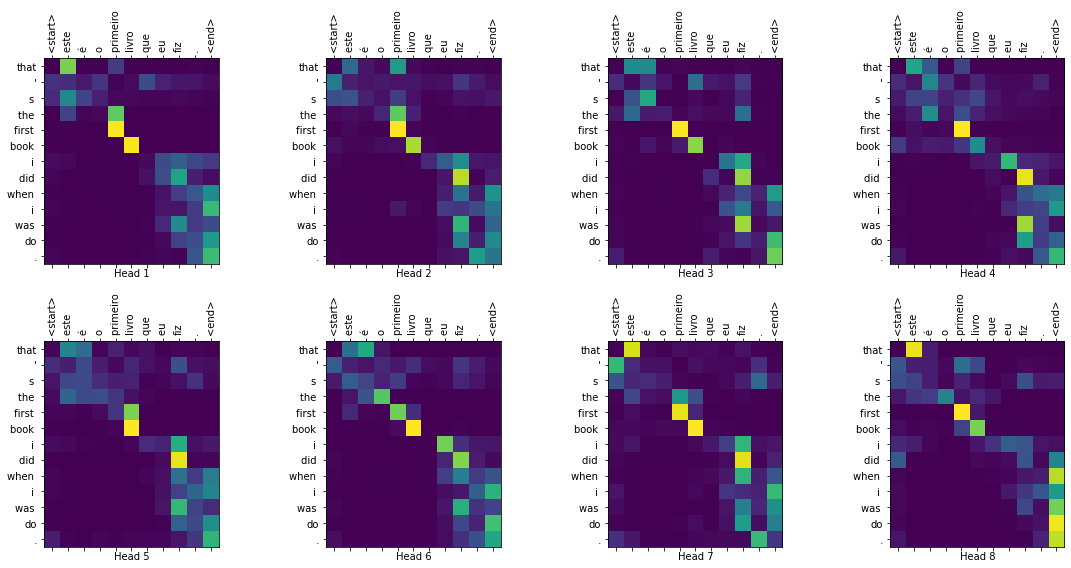

Real translation: this is the first book i've ever done.


In [61]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

In [63]:
!pip install nltk
import nltk

     |████████████████████████████████| 1.4 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 662 kB 11.2 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1435510 sha256=c86ed2f147d34e83e7c1d31ee13cfccef5cf4179fd294f3259cbe4bc6dee4fcf
  Stored in directory: /root/.cache/pip/wheels/de/5e/42/64abaeca668161c3e2cecc24f864a8fc421e3d07a104fc8a51
Successfully built nltk


In [68]:
from nltk.translate.bleu_score import sentence_bleu
reference = ["this is a problem we have to solve .".split( )]
candidate = "this is a problem we need to solve us .".split( )
score = sentence_bleu(reference, candidate)
print(score)

0.4671379777282001


In [69]:
reference = ["and my neighboring homes heard about this idea .".split( )]
candidate = "my neighbors heard about this idea .".split( )
score = sentence_bleu(reference, candidate)
print(score)

0.4835447404743731


In [73]:
translate("Ola meu nome é Harin.")
print ("Real translation: Hello my name is Harin .")

Input: Ola meu nome é Harin.
Predicted translation: i made my name is baln .
Real translation: Hello my name is Harin .


In [79]:
reference = ["Hello my name is Harin .".split( )]
candidate = "i made my name is baln .".split( )
score = sentence_bleu(reference, candidate)
print(score)

5.395774370246974e-78
